# Spotify Extended History

The following notebook is an experimental exploration of Spotify's **Extended History**.
The data is requested from Spotify and contains every individual play (by my account) from **October 2015** until **March 2023**.

In [33]:
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
import ipywidgets
from IPython.display import Markdown, display
from dotenv import load_dotenv

In [84]:
data_source = "./data/ole/"
paths = Path(data_source).glob("endsong*.json")
df = pd.concat(map(pd.read_json, paths))
df.iloc[[0,-1]]

,ts,username,platform,ms_played,conn_country,ip_addr_decrypted,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,...,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2015-10-04T17:25:52Z,thatollom,"Android OS 4.4.2 API 19 (THL, thl 5000)",121393,DE,95.91.224.1,unknown,Play Hard (feat. Ne-Yo & Akon),David Guetta,Nothing but the Beat,...,NaN,NaN,NaN,clickrow,endplay,False,1.0,False,0,False
6038,2023-05-14T22:12:55Z,thatollom,ios,154381,DE,37.4.229.9,unknown,Dawn of the Dragonstar,Twilight Force,Dawn of the Dragonstar,...,None,None,None,trackdone,endplay,False,1.0,False,1684074699,False


Remove known artists, that cannot be used in a music listening analysis. 

In [85]:
df.drop(columns=["username", "ip_addr_decrypted", "user_agent_decrypted", "offline_timestamp", "incognito_mode"], inplace=True)
df = df.drop(df[df["master_metadata_album_artist_name"] == "Die drei !!!"].index)
df = df.drop(df[df["master_metadata_album_artist_name"] == "Rick Riordan"].index)

In [86]:
df["ts"] = pd.to_datetime(df["ts"])
original_length = len(df)

In [87]:
unique_tracks = df["master_metadata_track_name"].unique()
print(len(unique_tracks), "unique tracks have been played")

17618 unique tracks have been played


In [88]:
df.groupby(df["master_metadata_track_name"])["spotify_track_uri"].first().to_frame().to_csv("tracks_with_uri_niklas.csv")

---
**Data:**
- `df` All columns; Only songs that have been played at least 10 times.
- `df_orig` All columns.
- `unique_tracks` Every track played.

**Edit:**
Upon further inspection, the 2015 data appear to be characterisec by irregular usage and a general lack of significance and thus will be excluded from the dataset.

In [89]:
df_top_tracks = df["master_metadata_track_name"].value_counts().to_frame()
df_top_tracks = df_top_tracks.reset_index().rename(columns={"master_metadata_track_name":"name","count":"plays"})
df_top_tracks.head()

,name,plays
0,T-Shirt Song,199
1,Nothing,187
2,Punk Rock Songs,178
3,"Young, Wild & Free (feat. Bruno Mars)",173
4,Young as the Morning Old as the Sea,169


In [90]:
top_names = df_top_tracks[df_top_tracks["plays"]>=10]["name"]
df_orig = df
df = df[df["master_metadata_track_name"].isin(top_names)].reset_index(drop=True)
# Edit:
df = df[df["ts"].dt.year != 2015]

print("original length:", original_length)
print(" reduced length:", len(df))
print("      reduction:", str(round(len(df)/original_length*100,2))+"%")

original length: 78415
 reduced length: 41439
      reduction: 52.85%


<div class="alert alert-block alert-success"> 
    It could be useful to further only include tracks,
    that have been played at lead 30% (or 50%) of their length. <br>
    Including skipped tracks carries the risk of further distorting the real hearing-bahavior.

</div>

In [91]:
num_skipped = len(df_orig[df_orig["skipped"] == 1])
print(round(num_skipped/len(df_orig)*100,2), "% of tracks have been skipped.") 

2.39 % of tracks have been skipped.


Though only a small percentage of tracks have been skipped, it is unlikeley, that the remaining tracks have been played to the end.


In [70]:
reason_end_count = df_orig["reason_end"].value_counts(normalize=True).to_frame().reset_index().rename({"count":"reason_end"}, axis=1)
reason_end_count

,reason_end,proportion
0,trackdone,0.642952
1,fwdbtn,0.180968
2,endplay,0.128314
3,unexpected-exit-while-paused,0.026540
4,backbtn,0.009750
5,logout,0.004924
6,unknown,0.002515
7,remote,0.001984
8,,0.001426
9,unexpected-exit,0.000407


<Axes: xlabel='proportion', ylabel='reason_end'>

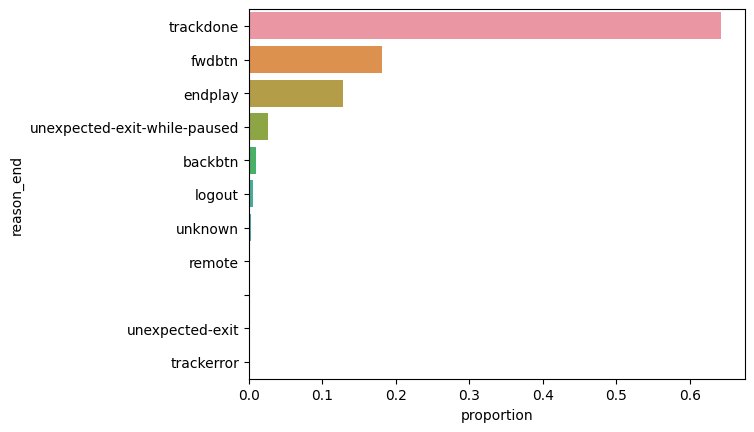

In [71]:
sns.barplot(data=reason_end_count, x="proportion", y="reason_end")

---
Songs played per year.

(only skipped excluded)

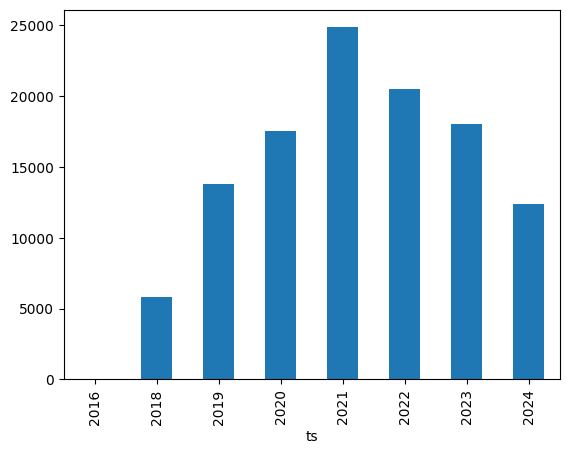

In [72]:
df_orig.groupby(df_orig["ts"].dt.year)["ts"].count().plot(kind="bar")
plt.show()

---
Songs per year per quarter.

<Axes: xlabel='ts'>

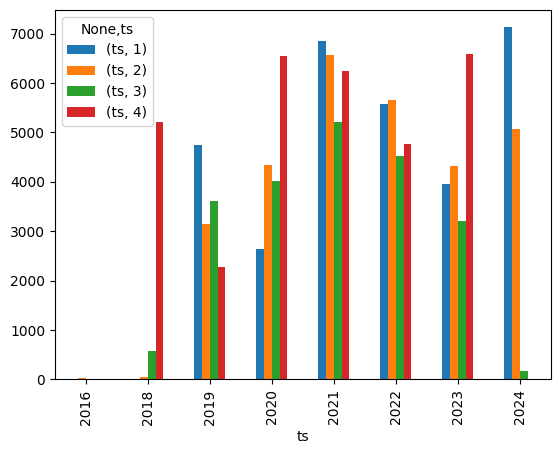

In [73]:
df_my = df_orig.groupby([df_orig["ts"].dt.year, df_orig["ts"].dt.quarter])["ts"].agg("count").to_frame()
df_my.index.sortlevel(0, sort_remaining=True)
df_my.unstack().plot(kind="bar", stacked=False)

---
Finding the longes heared tracks.

In [74]:
##### config ######
calculate = True
###################

if calculate:
    df_playcount = df["master_metadata_track_name"].value_counts().to_frame()
    df_from_to = pd.DataFrame(columns=["track_name", "plays", "first_played", "last_played", "days_between", "days_played"])

    for song, plays in tqdm(df_playcount.iterrows(), total=df_playcount.shape[0]):
        first_ts = df[df["master_metadata_track_name"] == song].iloc[0]["ts"]
        last_ts = df[df["master_metadata_track_name"] == song].iloc[-1]["ts"]

        df_ts = df.set_index("ts")
        df_ts_filtered = df_ts[df_ts["master_metadata_track_name"] == song]
        days_played = len(df_ts_filtered.groupby(df_ts_filtered.index.date).count())

        row = {
            "track_name": song,
            "plays": plays.values[0],
            "first_played": first_ts,
            "last_played": last_ts,
            "days_between": (last_ts - first_ts).days,
            "days_played": days_played,
        }
        new_df = pd.DataFrame([row])
        df_from_to = pd.concat([df_from_to, new_df], ignore_index=True)

    df_from_to.to_csv("df_from_to_niklas.csv")
else:
    df_from_to = pd.read_csv("df_from_to_niklas.csv")

df_from_to

 65%|█████████████████████████▎             | 1505/2321 [01:38<00:53, 15.23it/s]


KeyboardInterrupt: 

---
Top five songs per year with individual plays.

In [ ]:
df.groupby(df["ts"].dt.year)["master_metadata_track_name"].value_counts().groupby(level=0, group_keys=False).head(5)

---
Histogram individual plays, per year.

In [ ]:
plays_by_year = df.groupby(df["ts"].dt.year)["master_metadata_track_name"].value_counts().to_frame()
plays_by_year.index.rename(["year", "track_name"], inplace=True)
plays_by_year = plays_by_year.reset_index()
plays_by_year.rename({"count":"individual_plays"},axis=1, inplace=True)
plays_by_year.head(3)

In [ ]:
# pby = plays_by_year[plays_by_year["individual_plays"] < 50]
sea = sns.FacetGrid(plays_by_year[["year", "individual_plays"]], col="year", col_wrap=3)

plot = sea.map_dataframe(sns.histplot, "individual_plays", stat="percent", discrete=True)
year_counts = plays_by_year["individual_plays"].groupby(plays_by_year["year"]).count().reset_index(name="plays").set_index("year")
### Jupyter Setup ###
out1 = ipywidgets.widgets.Output()
with out1:
    display(year_counts)
out2 = ipywidgets.widgets.Output()
with out2:
    display(plot)
    plt.show()
two_columns = ipywidgets.widgets.HBox([out1, out2])
display(two_columns)

---
Portion of the top **5 (10, 20)** songs of the month in total plays.
> **TODO:** Amount of unique tracks that month

In [ ]:
##### config #####
calculate = True
##################

if calculate:
    top_n = [5, 10, 20]
    dfs = []
    dates = df_orig["ts"].dt.strftime("%y - %m").drop_duplicates().tolist()
    for n in top_n:
        df_top_month = pd.DataFrame(columns=["plays"], index=dates)
        for date in tqdm(df_top_month.index):
            entries = df_orig[df_orig["ts"].dt.strftime("%y - %m") == date]
            total_plays = len(entries)
            s_top_n = entries["master_metadata_track_name"].value_counts().head(n)
            top_n_plays = s_top_n.sum()
            top_n_tracks = s_top_n.index.tolist()
            top_n_portion = round(top_n_plays / total_plays * 100, 2)
            df_top_month.at[date] = top_n_portion
        dfs.append(df_top_month)

    df_top_all_n = pd.concat(dfs, axis=1)
    df_top_all_n.index = pd.to_datetime(df_top_all_n.index, format="%y - %m")
    df_top_all_n.columns = ["plays5","plays10", "plays20"]
    df_top_all_n.to_csv("df_top_all_n_niklas.csv")
else:
    df_top_all_n = pd.read_csv("df_top_all_n_niklas.csv")

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=df_top_all_n[["plays5", "plays10", "plays20"]])

---
Graphing the five most played song with their respective **plays per month**.

In [ ]:
top10 = df["master_metadata_track_name"].value_counts().iloc[:5].index.values
data = df[df["master_metadata_track_name"].isin(top10)]
data = data.groupby([data["ts"].dt.year, data["ts"].dt.month], group_keys=False) \
    ["master_metadata_track_name"].value_counts().to_frame().rename_axis(["year", "month", "track_name"]).reset_index(2) \
    .rename({"count":"plays"}, axis=1).reset_index()
data["date"] = pd.to_datetime(data[["year", "month"]].assign(DAY=1))
data = data.drop(["year", "month"], axis=1)


ax = sns.lineplot(data=data, x="date", y="plays", hue="track_name")
sns.move_legend(ax, "center left", bbox_to_anchor=(1.1,0.5))
plt.savefig("./top_tracks_when.png", transparent=True)

---
Hearing by Weekday.

In [ ]:
df_weekday_plays = df_orig.groupby(df_orig["ts"].dt.weekday)["ts"].count().to_frame()
df_weekday_plays.index.rename("weekday", inplace=True)
df_weekday_plays.reset_index(inplace=True)
df_weekday_plays.rename({"ts":"count"}, inplace=True, axis=1)

sns.barplot(data=df_weekday_plays, x="weekday", y="count", color="lightblue")

In [ ]:
df_weekday_plays = df_orig.groupby(df_orig["ts"].dt.hour)["ts"].count().to_frame()
df_weekday_plays.index.rename("hour", inplace=True)
df_weekday_plays.reset_index(inplace=True)
df_weekday_plays.rename({"ts":"count"}, inplace=True, axis=1)

sns.barplot(data=df_weekday_plays, x="hour", y="count", color="lightblue")

In [ ]:
df_weekday_plays = df_orig.groupby([df_orig["ts"].dt.weekday, df_orig["ts"].dt.hour])["ts"].count().to_frame()
df_weekday_plays.columns = ["count"]
df_weekday_plays.index.rename(["weekday", "hour"], inplace=True)
df_weekday_plays = df_weekday_plays.reset_index()

sea = sns.FacetGrid(df_weekday_plays, col="weekday")
sea.map(sns.barplot, "hour", "count", color="lightblue")

---
# Interpretes

In [ ]:
df_artist = df_orig[["ts", "master_metadata_track_name", "master_metadata_album_artist_name"]].rename(\
    columns={"master_metadata_track_name":"track_name","master_metadata_album_artist_name":"artist_name"})
df_artist.head()

In [ ]:
n = 10
top_n = df_artist.groupby(df_artist["ts"].dt.year)["artist_name"].value_counts().groupby(level=0, group_keys=False).head(n).to_frame().reset_index()
top_n["songs"] = np.zeros(len(top_n)).astype(int)
top_n["var"] = np.zeros(len(top_n))
top_n["std"] = np.zeros(len(top_n))
for i, row in top_n.iterrows():
    data = df_artist.loc[(df_artist["artist_name"] == row["artist_name"]) & (df_artist["ts"].dt.year == row["ts"])]
    individual_tracks = data["track_name"].value_counts()
    top_n.at[i, "songs"] = len(individual_tracks)
    top_n.at[i, "var"] = individual_tracks.var()
    top_n.at[i, "std"] = individual_tracks.std()
top_n = top_n.round(2)
top_n.head(3)

In [ ]:
top_n.sort_values("count", ascending=True)[:20]

---
## Artist stats

In [ ]:
### config ###
calculate = True
##############

if calculate:
    df_art = df_artist["artist_name"].value_counts().to_frame().reset_index().rename(columns={"count":"plays"})
    df_art["songs"] = np.zeros(len(df_art)).astype(int)
    df_art["var"] = np.zeros(len(df_art))
    df_art["std"] = np.zeros(len(df_art))
    for i, row in df_art.iterrows():
        data = df_artist.loc[df_artist["artist_name"] == row["artist_name"]]
        individual_tracks = data["track_name"].value_counts()
        df_art.at[i, "songs"] = len(individual_tracks)
        df_art.at[i, "var"] = individual_tracks.var()
        df_art.at[i, "std"] = individual_tracks.std()
    df_art.to_csv("df_art_niklas.csv")
else:
    df_art = pd.read_csv("df_art.csv")
df_art.head(3)

---
# Listening time

In [92]:
df_ms = df_orig[["ts", "ms_played", "master_metadata_track_name", "master_metadata_album_artist_name"]]
df_ms = df_ms.rename(columns={"master_metadata_track_name":"track_name", "master_metadata_album_artist_name":"artist_name"})
df_ms.head()

,ts,ms_played,track_name,artist_name
0,2015-10-04 17:25:52+00:00,121393,Play Hard (feat. Ne-Yo & Akon),David Guetta
1,2015-10-04 17:26:12+00:00,17666,A Brief Tutorial On Vip Production - Vip,Dubba Jonny
2,2015-10-04 17:26:24+00:00,16346,No Holds Barred - Excision Remix,Foreign Beggars
3,2015-10-04 17:26:26+00:00,3065,Clowns - Milo & Otis Trap VIP,KillaGraham
4,2015-10-04 17:27:00+00:00,36713,Defend Earth - Original Mix,Sub Antix


### Basic stats

Time played: 4067.3 hours or 169.47 days 

 Per year: Axes(0.125,0.11;0.775x0.77)


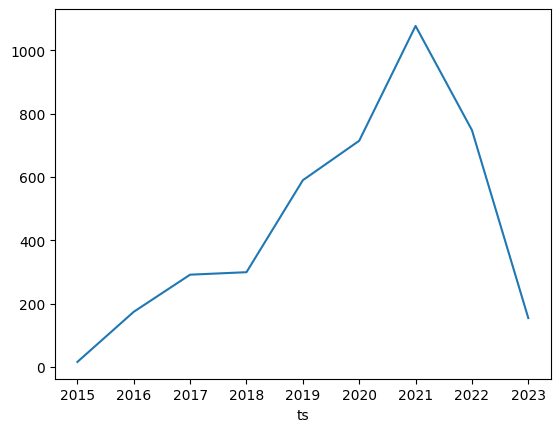

In [93]:
time_sum = df_ms["ms_played"].sum()
dates = df_ms["ts"].dt.strftime("%y - %m").drop_duplicates().tolist()
time_year = df_ms.groupby(df_ms["ts"].dt.year)["ms_played"].sum().apply(lambda x: x/1000/60/60).plot()
print(f"Time played: {np.round(time_sum/1000/60/60, 2)} hours or {np.round(time_sum/1000/60/60/24, 2)} days \n\n Per year: {time_year}")

Time played: 151.65 hours or 6.32 days 

 Per year: Axes(0.125,0.11;0.775x0.77)


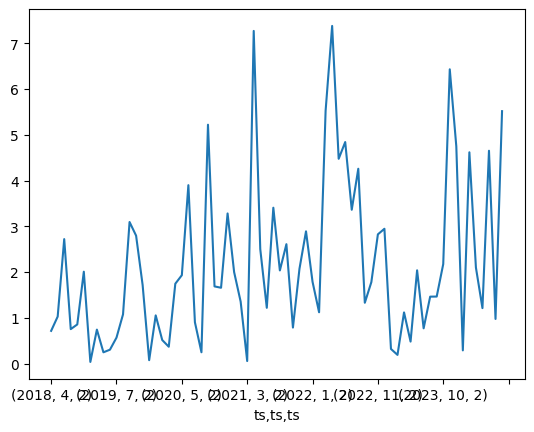

In [79]:
wed_data = df_ms[df_ms.ts.dt.day == 2]
time_sum = wed_data["ms_played"].sum()
dates = wed_data["ts"].dt.strftime("%y - %m").drop_duplicates().tolist()
time_year = wed_data.groupby([wed_data["ts"].dt.year, wed_data["ts"].dt.month, wed_data["ts"].dt.day])["ms_played"].sum().apply(lambda x: x/1000/60/60).plot()
print(f"Time played: {np.round(time_sum/1000/60/60, 2)} hours or {np.round(time_sum/1000/60/60/24, 2)} days \n\n Per year: {time_year}")

<Axes: xlabel='ts,ts'>

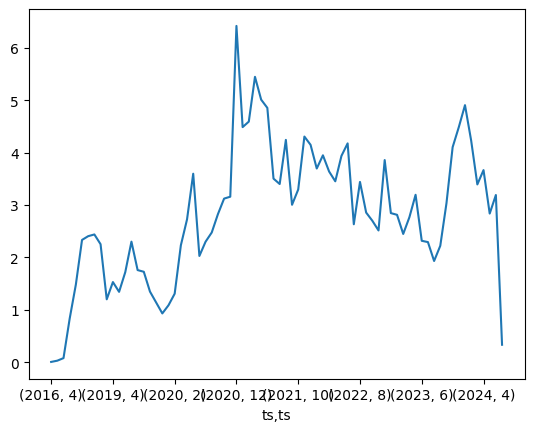

In [78]:
time_yearmonth = df_ms.groupby([df_ms["ts"].dt.year, df_ms["ts"].dt.month])["ms_played"].sum().apply(lambda x: x/1000/60/60/24)
time_yearmonth.plot()

---
## Playtime per song

In [ ]:
song_playtime = df_ms.groupby("track_name")["ms_played"].mean()
song_playtime

---
#Ideas
- 💡 for every year, number of songs played for that amount
- top song percentage
- genre breaks
- play peaks / lows
- top genres
- genre percentage
- interpret percentage
- popularity stats
- top interpretes
- mean playtime @(month/day/hour)
- skipped
    - time
    - percentage
    - heared again?
    - skipped early/late -> heared again?
    - main genre? -> skipped?
- session recognition?
- song cluster